# Summary

Exploration of a geomorphic Hamiltonian for hillslopes & rockslopes.

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
    pr_filenames = ['Hillslope_tanbeta_n1']
    # pr_filenames = ['Hillslope_tanbeta_n2']
    pr_filenames = ['Hillslope_sinbeta_n1']
    # pr_filenames = ['Hillslope_sinbeta_n2']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Logging

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s')

### Modules

In [3]:
# Import Numpy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
import sympy as sy
from sympy import (
    Eq,
    lambdify,
    sin,
    cos,
    Rational,
    sqrt,
    solve,
    N,
    init_printing,
    trigsimp,
    rad,
    Symbol,
    Function,
    exp,
    tan,
    asin,
    Abs,
    simplify,
    diff,
    Matrix,
    powsimp,
    expand,
    factor,
    denom,
    numer,
    expand_trig,
)
from sympy.simplify.fu import TR2

# Set up latex inline printing
init_printing(use_unicode=True, pretty_print=True, wrap_line=True)

# Pretty dict printing etc
from pprint import PrettyPrinter

pp = PrettyPrinter(indent=4).pprint

# Import Geomorphysics library functions, classes
from gmplib.utils import e2d
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters
from gmplib.plot import GraphingBase

from matplotlib import pyplot as plt

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
# from gme.core.symbols import *
from gme.core.symbols import (
    xi_h0,
    xi_h,
    n_h,
    phi,
    alpha,
    beta,
    Fstar,
    H,
    lmbda,
    rdotx,
    rdotz,
    p,
)
from gme.core.equations import Equations

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if "GME_WORKING_PATH" in os.environ.keys():
    working_path = os.environ["GME_WORKING_PATH"]
    print(
        f"Fetching working path from environment variable GME_WORKING_PATH = {working_path}"
    )
else:
    from gmplib.utils import get_pkg_path
    import gme

    working_path = get_pkg_path(gme)
    print(f"Deducing working path from GME package location = {working_path}")
    del gme

# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path, "Parameters", "Theory")
pr_path, pr_filenames


Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/Theory', ['Hillslope_sinbeta_n1'])

### Parameter parsing

In [4]:
parametehillslope_dict,_ = import_parameters(pr_path, [os.path.join('..','defaults'), *pr_filenames])
evaluations = {}
evaluations_sequence = ()
pr = Parameters(parametehillslope_dict, evaluations=evaluations, sequence=evaluations_sequence)
[pp(psubobj.__dict__) for psubobj in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/defaults.json
gmplib.parameters.read_json_file: /Users/colinstark/Projects/GME/Parameters/Theory/Hillslope_sinbeta_n1.json
gmplib.parameters.ParametersNestedGroup: p.job
gmplib.parameters.ParametersNestedGroup: p.model
gmplib.parameters.ParametersNestedGroup: p.solve
gmplib.parameters.ParametersNestedGroup: p.resolve
gmplib.parameters.ParametersNestedGroup: p.plot
gmplib.parameters.ParametersNestedGroup: p.save


{   'debug': False,
    'group_name': 'Notes',
    'short_name': 'hillslope',
    'subtitle': '',
    'title': 'Hillslope erosion with sin(beta) model, n=1',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_h_crit': pi/9,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    'n_h': 1,
    'phi_h': pi/4,
    't_xiv0_list': None,
    'varepsilonhat': 1/100,
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'x_h': 1,
    'x_sigma': 0.01,
    'xi_h0': 1,
    'xiv_0': None}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {   'Hamilton': 'DOP853',
                  'choices': ['RK45', 'RK23', 'Radau', 'DOP853', 'LSODA'],
                  'geodesic': 'LSODA'},
    'ray_n_t': 301,
    't_distribn': 2,
    't_end':

# Theory

### Basics

In [5]:
# gmeq = Equations( eta_=pr.model.eta, 
#                   mu_=pr.model.mu, 
#                   beta_type=pr.model.beta_type, 
#                   varphi_type=pr.model.varphi_type, 
# #                   ibc_type=pr.model.ibc_type,
#                   parameters=sub, 
#                   do_raw=False )

In [6]:
prefix = ("_").join(
    [pr.job.short_name, pr.model.beta_type + "beta", f"n{pr.model.n_h}"]
)
# prefix = ('_').join([pr.job.short_name, gmeq.beta_type+'beta', gmeq.varphi_type.replace('-','')])

suffix = ""  # f'_eta{float(N(gmeq.eta_))}'
# suffix += f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.2f}' if gmeq.mu/gmeq.eta==Rational(1,3) \
#                                     else f'_ratio{ float(sy.N(gmeq.mu/gmeq.eta)):0.1f}'
# suffix += f'_xiv{float(sy.N(pr.model.xiv_0)):1.0f}'
# suffix = (suffix if pr.model.varphi_type=='ramp' \
#             else suffix+f'_xh{float(gmes.parameters[x_h]):1.1f}').replace('.','p')

job_name = prefix + suffix.replace(".", "p")
job_name

'hillslope_sinbeta_n1'

### Erosion function

Remember that $p_z$ is NEGATIVE, but $\beta$ is required to be POSITIVE.

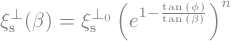

In [7]:
hillslope_tan_erosion_eqn = Eq(
    xi_h(beta), powsimp(xi_h0 * (exp(1 - tan(phi) / tan(beta)) ** n_h))
)
hillslope_tan_erosion_eqn

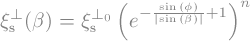

In [8]:
hillslope_sin_erosion_eqn = Eq(
    xi_h(beta), powsimp(xi_h0 * (exp(1 - sin(phi) / Abs(sin(beta))) ** n_h))
)
hillslope_sin_erosion_eqn

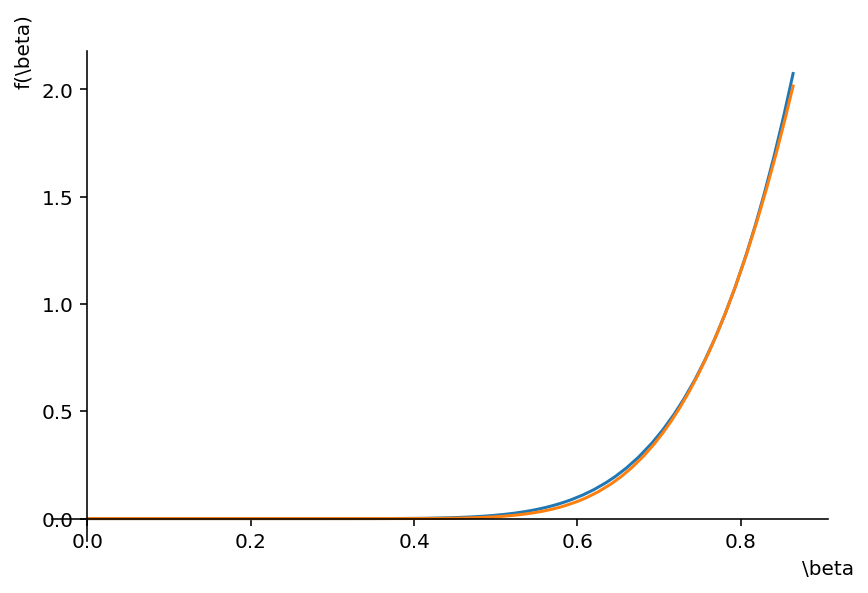

In [9]:
p1 = sy.plot(
    hillslope_tan_erosion_eqn.rhs.subs({phi: sy.pi / 4, xi_h0: 1, n_h: 5}),
    (beta, 0, sy.pi / 4 * 1.1),
    show=False,
)
p2 = sy.plot(
    hillslope_sin_erosion_eqn.rhs.subs({phi: sy.pi / 4, xi_h0: 1, n_h: 10}),
    (beta, 0, sy.pi / 4 * 1.1),
    show=False,
)
p1.extend(p2)
p1.show()

In [10]:
model_ = pr.model.beta_type
if model_=="tan":
    hillslope_erosion_eqn = hillslope_tan_erosion_eqn
elif model_=="sin":
    hillslope_erosion_eqn = hillslope_sin_erosion_eqn
else:
    print("Not implemented")

### Fundamental function & Hamiltonian

In [11]:
px: Symbol = Symbol(r"p_x", real=True, positive=True)
pz: Symbol = Symbol(r"p_z", real=True, negative=True)

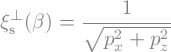

In [12]:
xih_pxpz_eqn = Eq(xi_h(beta), 1/sqrt(px**2+pz**2))
xih_pxpz_eqn

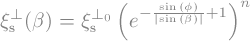

In [13]:
hillslope_erosion_eqn

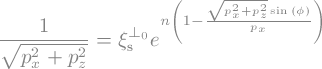

In [14]:
hillslope_pxpz_eqn = (
    hillslope_erosion_eqn
        .subs(e2d(xih_pxpz_eqn))
        .subs({tan(beta):(-px/pz)})
        .subs({sin(beta):(px/sqrt(px**2+pz**2))})
)
hillslope_pxpz_eqn

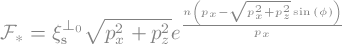

In [15]:
Fstar_hillslope_pxpz_eqn = Eq(
    Fstar,
    solve(simplify(hillslope_pxpz_eqn.subs({px: px/Fstar, pz: pz/Fstar})), Fstar)[
        0
    ],
)
Fstar_hillslope_pxpz_eqn

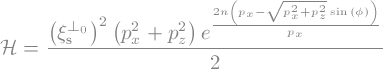

In [16]:
H_hillslope_pxpz_eqn = Eq(H, Fstar_hillslope_pxpz_eqn.rhs**2 / 2)
H_hillslope_pxpz_eqn

Check Euler homogeneity

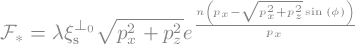

In [17]:
simplify( Fstar_hillslope_pxpz_eqn.subs({px:lmbda*px, pz:lmbda*pz}) )

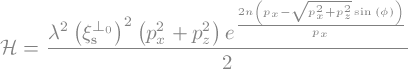

In [18]:
simplify( H_hillslope_pxpz_eqn.subs({px:lmbda*px, pz:lmbda*pz}) )

### Hamilton's equations

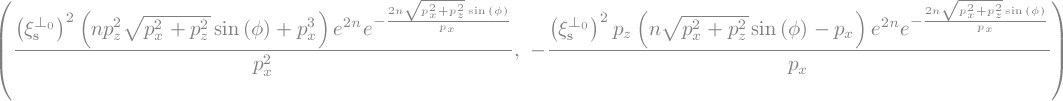

In [19]:
v_pxpz_eqn = Eq(
    Matrix([rdotx, rdotz]),
    Matrix(
        [
            factor(simplify(diff(H_hillslope_pxpz_eqn.rhs, px))),
            factor(simplify(diff(H_hillslope_pxpz_eqn.rhs, pz))),
        ]
    )
)
(
    v_pxpz_eqn.rhs[0],
    v_pxpz_eqn.rhs[1],
)


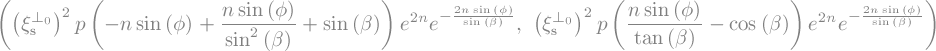

In [20]:
v_p_beta_eqn = (
    trigsimp( v_pxpz_eqn.subs({px:p*sin(beta), pz:-p*cos(beta)}) )
)
(v_p_beta_eqn.rhs[0], v_p_beta_eqn.rhs[1], )


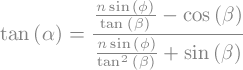

In [21]:
tanalpha_eqn = Eq(
    tan(alpha),
    trigsimp( v_p_beta_eqn.rhs[1]/v_p_beta_eqn.rhs[0] )
)
tanalpha_eqn

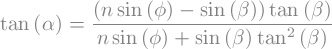

In [22]:
simplify(tanalpha_eqn)

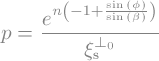

In [23]:
p_conjugate_beta_eqn = Eq(
    p,
    powsimp(solve(
        simplify(
            Eq(
                (v_p_beta_eqn.rhs[0] * px + v_p_beta_eqn.rhs[1] * pz).subs(
                    {px: p*sin(beta), pz: -p*cos(beta)}
                ),
                1,
            )
        ),
        p,
    )[0]),
)
p_conjugate_beta_eqn


### Choose some parameters

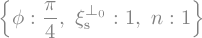

In [24]:
n_ = pr.model.n_h #Rational(1,2)
phi_ = pr.model.phi_h
xi_h0_ = pr.model.xi_h0

beta_ = np.pi/5

sub_ = {xi_h0:xi_h0_, n_h:n_, phi:phi_}
sub_

### Try to locate critical angles

In [25]:
tanalpha_eqn_tmp = simplify(tanalpha_eqn)
_ = Eq(
    (tanalpha_eqn_tmp.lhs*denom(tanalpha_eqn_tmp.rhs))**2,
    (numer(tanalpha_eqn_tmp.rhs))**2
    # tanalpha_eqn_tmp.lhs*denom(tanalpha_eqn_tmp.rhs),numer(tanalpha_eqn_tmp.rhs)
)
_

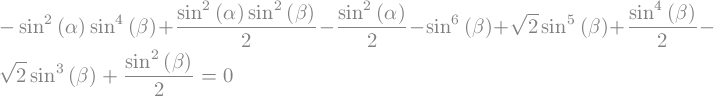

In [26]:
_ = (TR2((_))).subs({cos(beta):sqrt(1-sin(beta)**2)})
tmp = factor(Eq(
    numer(_.lhs)*denom(_.rhs)-
    numer(_.rhs)*denom(_.lhs),
    0
))
sinalpha_sinbeta_eqn = Eq(simplify(numer(tmp.subs(sub_).lhs)),0)
sinalpha_sinbeta_eqn

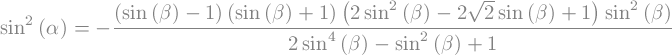

In [27]:
sinalpha2_eqn = factor(Eq(
    sin(alpha) ** 2,
    (solve(sinalpha_sinbeta_eqn, sin(alpha) ** 2)[0]).subs(
        {cos(beta) ** 2: 1 - sin(beta) ** 2}
    )
))
sinalpha2_eqn


In [28]:
tmp3 = (numer(sinalpha2_eqn.rhs).args[-1])
tmp3

In [29]:
asin(solve(tmp3, sin(beta))[0])

In [30]:
tmp4 = denom(sinalpha2_eqn.rhs)
tmp4

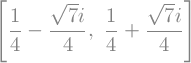

In [31]:
solve(tmp4, sin(beta)**2)

Solutions for $\beta$. But beware, we have defined (to enable earlier simplifications) $\beta$ to be positive, so the zero and negative solutions here will cause problems.

In [32]:
[asin(soln_).n() for soln_ in solve(sinalpha_sinbeta_eqn.subs({alpha:0}), sin(beta))]

In [33]:
[asin(soln_).n() for soln_ in solve(sinalpha_sinbeta_eqn.subs({beta:sy.pi/3}), sin(alpha))]

### Figuratrix

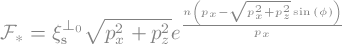

In [34]:
Fstar_hillslope_pxpz_eqn

In [35]:
fgtx_raw_eqn = simplify(
    Fstar_hillslope_pxpz_eqn
        .subs({Fstar:1})
        .subs({px:p*sin(beta), pz:-p*cos(beta)})
)
fgtx_raw_eqn

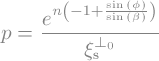

In [36]:
fgtx_p_beta_eqn = Eq(
    p,
    solve( fgtx_raw_eqn, p )[0]
)
fgtx_p_beta_eqn

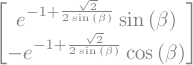

In [37]:
p_covec_fn_ = Matrix([
    (fgtx_p_beta_eqn.rhs*sin(beta)).subs(sub_),
    (-fgtx_p_beta_eqn.rhs*cos(beta)).subs(sub_)
])
# sy.plot_parametric( px_fn,pz_fn, (beta,0.2,sy.pi/3) );
p_covec_fn_

In [38]:
px_lmbda_ = lambdify([beta], p_covec_fn_[0])
pz_lmbda_ = lambdify([beta], p_covec_fn_[1])
p_lmbda_ = lambdify([beta], sqrt(p_covec_fn_[0]**2+p_covec_fn_[1]**2))
px_lmbda_(beta_), pz_lmbda_(beta_), p_lmbda_(beta_)

Check conjugacy.

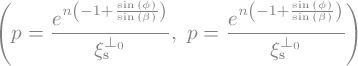

In [39]:
fgtx_p_beta_eqn, p_conjugate_beta_eqn

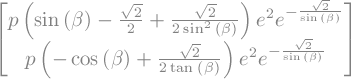

In [40]:
v_vec_fn_ =  v_p_beta_eqn.rhs.subs(sub_)
v_vec_fn_

### Indicatrix

In [41]:
vx_lmbda_ = lambdify(
    [beta],
    v_vec_fn_[0].subs({p: sqrt(p_covec_fn_[0] ** 2 + p_covec_fn_[1] ** 2)}),
)
vz_lmbda_ = lambdify(
    [beta],
    v_vec_fn_[1].subs({p: sqrt(p_covec_fn_[0] ** 2 + p_covec_fn_[1] ** 2)}),
)
v_lmbda_ = lambdify(
    [beta],
    sqrt(v_vec_fn_[0] ** 2 + v_vec_fn_[1] ** 2).subs(
        {p: sqrt(p_covec_fn_[0] ** 2 + p_covec_fn_[1] ** 2)}
    ),
)
vx_lmbda_(beta_), vz_lmbda_(beta_), v_lmbda_(beta_)


In [42]:
vx_lmbda_(beta_)*px_lmbda_(beta_) + vz_lmbda_(beta_)*pz_lmbda_(beta_)

# Plot

### Prep

In [43]:
angles_markup = {
    1: {
        0.01: {
            "colors": ["DarkBlue","DarkRed"],
            "marker": "o",
            "label": r'$\beta=0$',
            "size": 6
        },
        sy.pi/9: {
            "colors": ["lightseagreen","violet"],
            "marker": "^",
            "label": r'$\beta=\pi/9$',
            "size": 9
        },
        sy.pi/4: {
            "colors": ["b","r"],
            "marker": "h",
            "label": r'$\beta=\pi/4$',
            "size": 6
        },
        sy.pi/3: {
            "colors": ["b","r"],
            "marker": "p",
            "label": r'$\beta=\pi/3$',
            "size": 6
        },
        sy.pi/2: {
            "colors": ["b","r"],
            "marker": "s",
            "label": r'$\beta=\pi/2$',
            "size": 6
        },
    },
    2: {
        0.01: {
            "colors": ["DarkBlue","DarkRed"],
            "marker": "o",
            "label": r'$\beta=0$',
            "size": 6
        },
        sy.pi/5: {
            "colors": ["lightseagreen","violet"],
            # "colors": ["LightBlue","Orange"],
            "marker": "^",
            "label": r'$\beta=\pi/5$',
            "size": 9
        },
        sy.pi/2: {
            "colors": ["b","r"],
            "marker": "s",
            "label": r'$\beta=\pi/2$',
            "size": 6
        },
    },
    3: {
        0.01: {
            "marker": ">",
            "label": r'$\beta=0$'
        },
        sy.pi/5: {
            "marker": "^",
            "label": r'$\beta=\pi/5$'
        },
        sy.pi/2: {
            "marker": "s",
            "label": r'$\beta=\pi/2$'
        },
    }
} if pr.model.beta_type=="sin" else {
    1: {
        0.01: {
            "colors": ["DarkBlue","DarkRed"],
            "marker": "o",
            "label": r'$\beta=0$',
            "size": 6
        },
        sy.pi/2: {
            "colors": ["b","r"],
            "marker": "s",
            "label": r'$\beta=\pi/2$',
            "size": 6
        },
    },        
    2: {
        0.01: {
            "colors": ["DarkBlue","DarkRed"],
            "marker": "o",
            "label": r'$\beta=0$',
            "size": 6
        },
        sy.pi/2: {
            "colors": ["b","r"],
            "marker": "s",
            "label": r'$\beta=\pi/2$',
            "size": 6
        },
    }
}
    

In [44]:
beta_array = np.linspace(0.01,np.pi/2*1,500)
px_array = px_lmbda_(beta_array) 
pz_array = pz_lmbda_(beta_array)
vx_array = vx_lmbda_(beta_array)
vz_array = vz_lmbda_(beta_array)
beta_array = beta_array[np.isfinite(vx_array)]
px_array = px_array[np.isfinite(vx_array)]
pz_array = pz_array[np.isfinite(vx_array)]
vx_array = vx_array[np.isfinite(vx_array)]
vz_array = vz_array[np.isfinite(vz_array)]

In [45]:
def mark_angles(n_,x_lmbda_,z_lmbda_, p_or_v=0):
    angles_markup_ = angles_markup[
        n_ if n_ in (1,2,3) else 1
    ]
    for angle_ in reversed(angles_markup_.keys()):
        angle_markup_ = angles_markup_[angle_]
        plt.plot(
                x_lmbda_(float(angle_)),
                z_lmbda_(float(angle_)),
                angle_markup_["marker"],
                color=angle_markup_["colors"][p_or_v],
                label=angle_markup_["label"],
                ms=angle_markup_["size"],
            )

In [46]:
gr = GraphingBase()

In [47]:
beta_crit_ = pr.model.beta_h_crit
beta_crit_

### Graphs

gmplib.plot.GraphingBase:
   Creating plot: hillslope_sinbeta_n1_figuratrix size=(8, 8) @ 100 dpi
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode


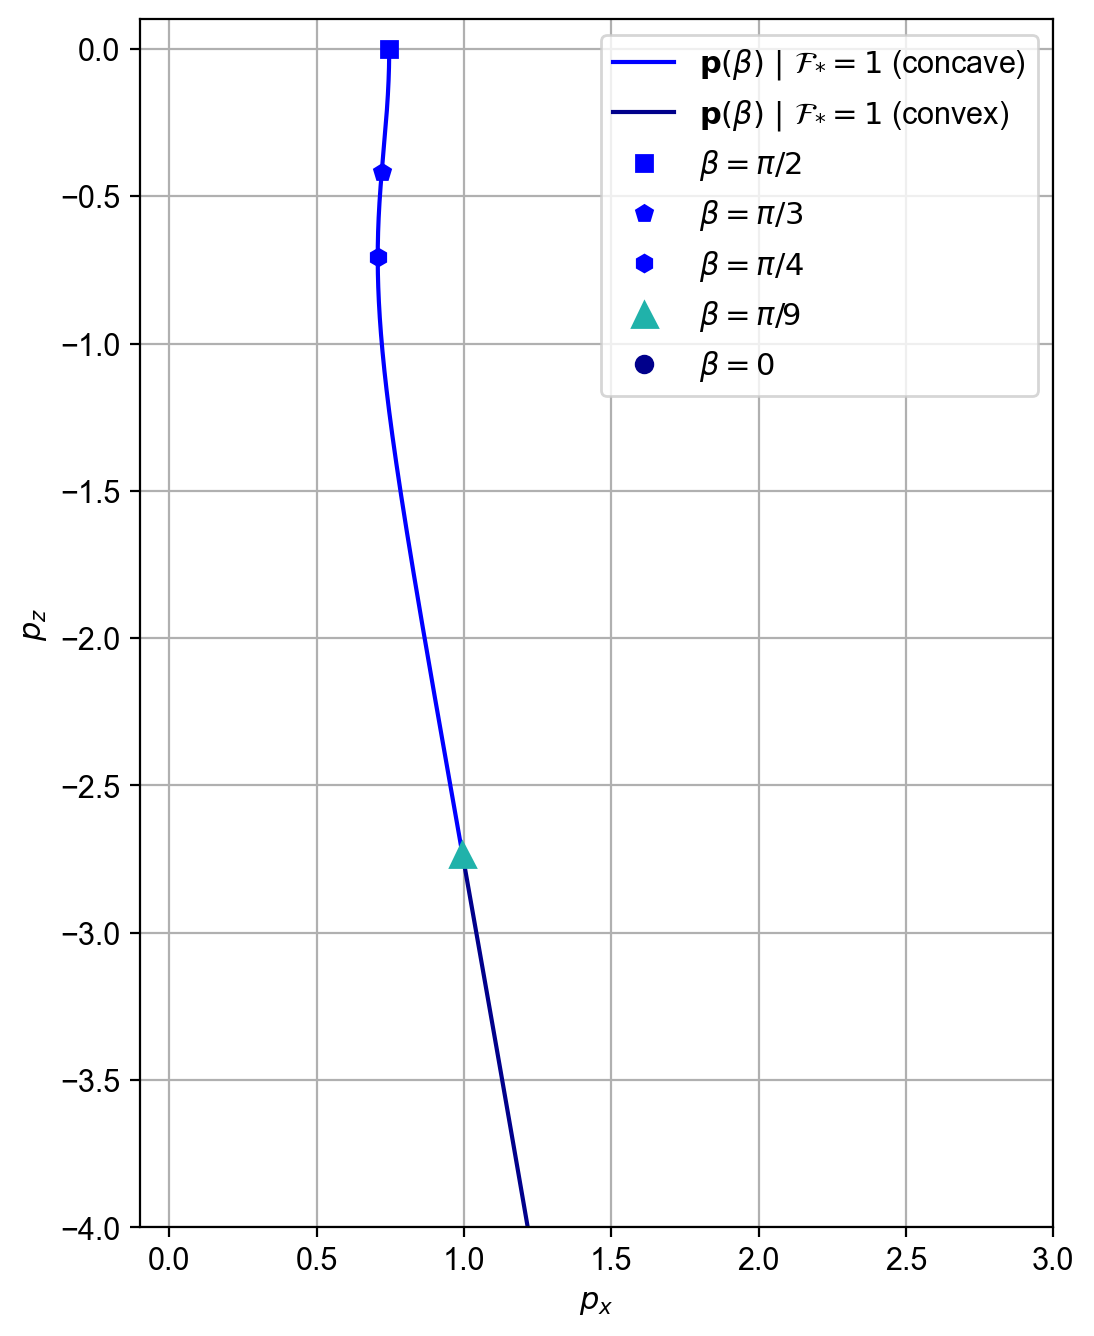

In [48]:
gr.create_figure(fig_name="_".join([job_name,"figuratrix"]))
if beta_crit_ is not None:
    plt.plot(
        px_array[beta_array>=beta_crit_],
        pz_array[beta_array>=beta_crit_],
        color='b',
        label=r"$\mathbf{p}(\beta) \,\,|\,\,\mathcal{F}_{*}=1$ (concave)",
    )
plt.plot(
    px_array[beta_array<=beta_crit_] if beta_crit_ is not None else px_array,
    pz_array[beta_array<=beta_crit_] if beta_crit_ is not None else pz_array,
    color='DarkBlue',
    label=r"$\mathbf{p}(\beta) \,\,|\,\,\mathcal{F}_{*}=1$ (convex)",
)
plt.xlabel(r"$p_x$")
plt.ylabel(r"$p_z$")
mark_angles(n_, px_lmbda_, pz_lmbda_, p_or_v=0)
if pr.plot.fgtx_xlim is not None:
    plt.xlim(*pr.plot.fgtx_xlim)
if pr.plot.fgtx_ylim is not None:
    plt.ylim(*pr.plot.fgtx_ylim)
axes = plt.gca()
axes.set_aspect(1)
plt.grid(":")
plt.legend();

gmplib.plot.GraphingBase:
   Creating plot: hillslope_sinbeta_n1_indicatrix size=(8, 8) @ 100 dpi
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode


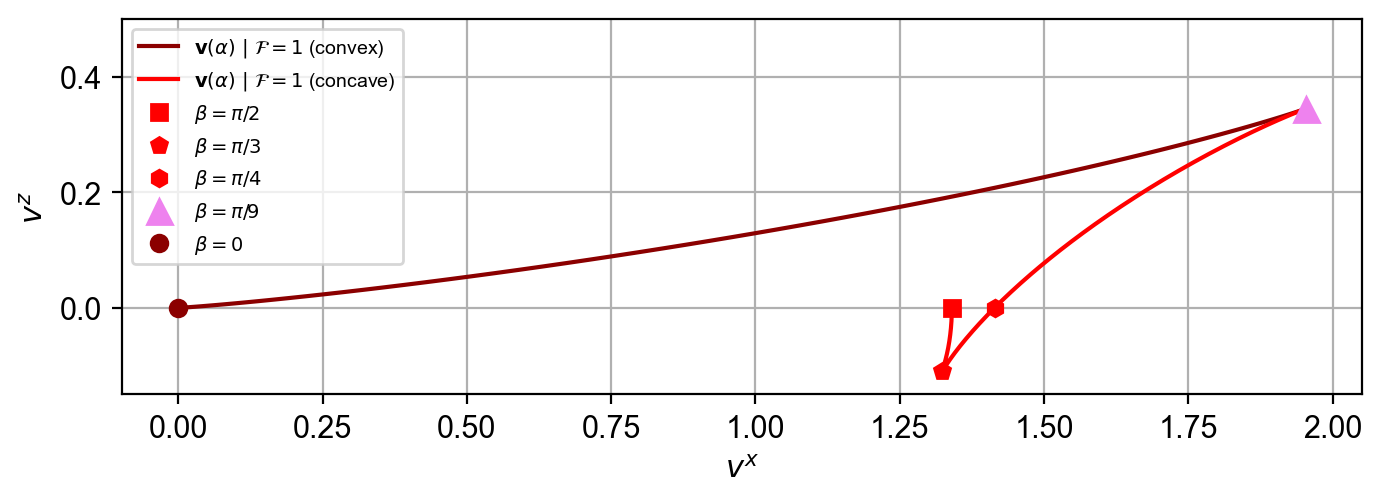

In [49]:
gr.create_figure(fig_name="_".join([job_name,"indicatrix"]))
plt.plot(
    vx_array[beta_array<=beta_crit_] if beta_crit_ is not None else vx_array,
    vz_array[beta_array<=beta_crit_] if beta_crit_ is not None else vz_array,
    color='DarkRed',
    label=r"$\mathbf{v}(\alpha) \,\,|\,\,\mathcal{F}=1$ (convex)",
)
if beta_crit_ is not None:
    plt.plot(
        vx_array[beta_array>=beta_crit_],
        vz_array[beta_array>=beta_crit_],
        color='r',
        label=r"$\mathbf{v}(\alpha) \,\,|\,\,\mathcal{F}=1$ (concave)",
    )
plt.xlabel(r"$v^x$")
plt.ylabel(r"$v^z$")
mark_angles(n_, vx_lmbda_, vz_lmbda_, p_or_v=1)
if pr.plot.idtx_xlim is not None:
    plt.xlim(*pr.plot.idtx_xlim)
if pr.plot.idtx_ylim is not None:
    plt.ylim(*pr.plot.idtx_ylim)
axes = plt.gca()
axes.set_aspect(1)
plt.grid(":")
plt.legend(loc='upper left', fontsize=pr.plot.idtx_fontsize);

# Save

In [50]:
pp(gr.fdict)

{   'hillslope_sinbeta_n1_figuratrix': <Figure size 800x800 with 1 Axes>,
    'hillslope_sinbeta_n1_indicatrix': <Figure size 800x800 with 1 Axes>}


In [51]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots(
    gr.fdict,
    plots_dir,
    pr.save.figs_format,
    suffix="",
    dpi=pr.save.figs_options["dpi"],
)

gmplib.save.export_plots:
   Writing to dir: "/Users/colinstark/Projects/GME/Plots/Notes"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
gmplib.save.export_plot: Exported "hillslope_sinbeta_n1_figuratrix.jpg"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
gmplib.save.export_plot: Exported "hillslope_sinbeta_n1_indicatrix.jpg"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
gmplib.save.export_plot: Exported "hillslope_sinbeta_n1_figuratrix.pdf"
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
Substituting symbol F from STIXNonUnicode
gmplib.save.export_plo